In [ ]:
# wandbai api key: 

In [10]:

import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


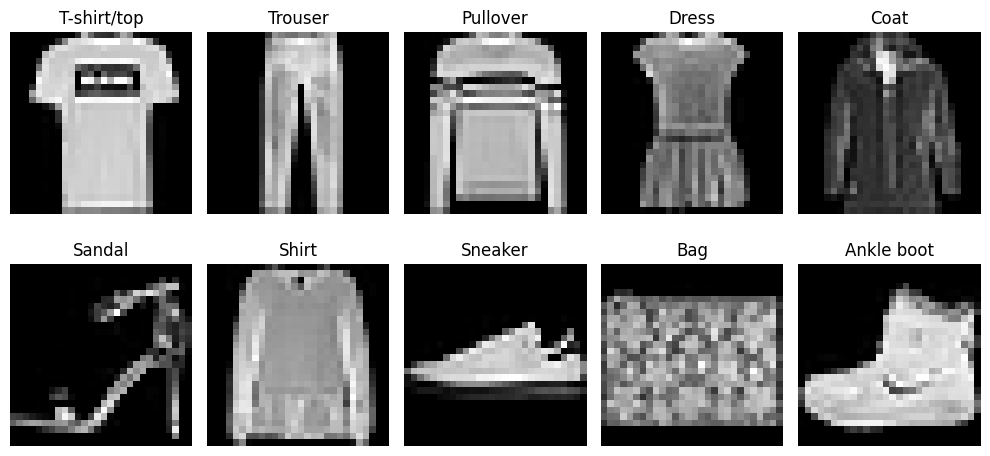

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist

# Load the Fashion-MNIST dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Create a figure and axes for the plot
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

# Iterate through each class
for i in range(10):
  # Find the index of the first image of the current class
  index = np.where(train_labels == i)[0][0]
  # Plot the image on the corresponding subplot
  row = i // 5
  col = i % 5
  axes[row, col].imshow(train_images[index], cmap='gray')
  axes[row, col].set_title(class_names[i])
  axes[row, col].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [18]:
# Load the Fashion-MNIST dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.1)

ix = np.random.randint(0, train_images.shape[0], (32,))
x = train_images[ix]
x = x.reshape(32, -1)
y = train_labels[ix]
y = np.eye(10)[y]

In [13]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:

  def __init__(self, fan_in, fan_out, weight_init = "Xavier", bias=True):

    self.cache = dict(x=None)
    self.gradd = dict(weight=None, bias=None)
    if weight_init == "Xavier":
      #XavierInit
      self.weight = np.random.randn(fan_in, fan_out) / (fan_in + fan_out)**0.5
      self.bias = np.zeros(fan_out, dtype="f") if bias else None
    else:
      #RandomInit
      self.weight = np.random.randn(fan_in, fan_out)
      self.bias = np.random.randn(fan_out) if bias else None

  def __str__(self):
      return "Linear({:d}, {:d}, bias={})".format(self.weight.shape[0], self.weight.shape[1], self.bias is not None)


  def __call__(self, x):
      self.out = x @ self.weight
      if self.bias is not None:
          self.out += self.bias
      # Store input for backward pass
      self.cache["x"] = x
      return self.out

  def grad(self, d_out):
    x = self.cache["x"]
    # Weight gradient: x^T @ d_out
    self.gradd["weight"] = x.T @ d_out

    dzdx = d_out@self.weight.T

    # Bias gradient: sum over batch
    if self.bias is not None:
        self.gradd["bias"] = np.sum(d_out, axis=0)

    # returning dzdx
    return dzdx

  def parameters(self):
    return [self.weight] + ([self.bias] if self.bias is not None else [])



# -----------------------------------------------------------------------------------------------

class Tanh:
  def __call__(self, x):
    self.x = x
    self.out = np.tanh(self.x)
    # self.cache = {"x": np.tanh(self.x)}
    return self.out
  def parameters(self):
    # Activation Function
    return []

  def grad(self, dout):
    return dout * (1 - self.out**2)


# -----------------------------------------------------------------------------------------------

class Sigmoid:
  def __call__(self, x):
      self.out = 1 / (1 + np.exp(-x))
      return self.out

  def grad(self, d_out):
      # sigmoid derivative: σ(x)(1 - σ(x))
      return (self.out * (1 - self.out)) * d_out

  def parameters(self):
      return []



# -----------------------------------------------------------------------------------------------


class Relu:
  def __call__(self, x):
      self.cache = {"x": x}
      self.out = np.maximum(0, x)
      return self.out

  def grad(self, d_out):
      x = self.cache["x"]
      dx = np.ones_like(x)
      dx[x < 0] = 0
      return np.array(d_out) * dx

  def parameters(self):
      return []


# -----------------------------------------------------------------------------------------------

class CrossEntropyLoss:

    def __init__(self, reduction='mean', eps=1e-12):  # More stable epsilon
        super().__init__()
        self.eps = eps
        self.reduction = reduction

    def __str__(self):
        return f'CrossEntropyLoss(reduction={self.reduction}, eps={self.eps})'

    def __call__(self, y, y_true):
        return self.forward(y, y_true)

    def forward(self, y, y_true):
        # Final layer activation is softmax and y here is logits
        exp_y = np.exp(y - np.max(y, axis=1, keepdims=True))
        probs = exp_y / np.sum(exp_y + 1e-12, axis=1, keepdims=True)

        # print(probs)


        # Clip probabilities to [eps, 1-eps] to avoid log(0) Done this aftis after many random trials
        clipped_probs = np.clip(probs[y_true.astype(bool)], self.eps, 1.0 - self.eps)

        per_sample_loss = -np.log(clipped_probs)

        if self.reduction == 'mean':
            return np.mean(per_sample_loss)
        elif self.reduction == 'sum':
            return np.sum(per_sample_loss)
        else:
            return per_sample_loss

    def grad(self, y, y_true):
        # Simple (1/B)*(One - hot vector - yhat)
        return (1.0 / y.shape[0]) * (y - y_true)  # Maintain gradient scaling
# -----------------------------------------------------------------------------------------------


class Sequential:

  def __init__(self, layers=None):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def append(self, layer):
    self.layers.append(layer)

  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

  def backward(self, d_out):
    # Backpropagate through layers in reverse order
    d = d_out
    gradients = []
    #storing layer.weight, layer.bias grad in a list also

    for layer in reversed(self.layers):
        d = layer.grad(d)
        if hasattr(layer, 'weight'):
            gradients.append(layer.gradd["bias"] if layer.bias is not None else None)
            gradients.append(layer.gradd["weight"])
    return d, list(reversed(gradients))

In [14]:
class Optimizer():
    def __init__(self, lr=0.001, optimizer="sgd", momentum=0.9,
                 epsilon=1e-8, beta=0.9, beta1=0.9, beta2=0.999, t=0, decay=0):
      self.lr = lr
      self.optimizer = optimizer
      self.momentum = momentum
      self.epsilon = epsilon
      self.beta = beta
      self.beta1 = beta1
      self.beta2 = beta2
      self.t = t
      self.decay = decay



    def __call__(self, param, dparam):
      self.t+=1
      self.run(param, dparam)

    def run(self, param, dparam):
        if(self.optimizer == "sgd"):
            self.SGD(param, dparam)
        elif(self.optimizer == "momentum"):
            self.MomentumGD(param, dparam)
        elif(self.optimizer == "nag"):
            self.NAG(param, dparam)
        elif(self.optimizer == "rmsprop"):
            self.RMSProp(param, dparam)
        elif(self.optimizer == "adam"):
            self.Adam(param, dparam)
        elif (self.optimizer == "nadam"):
            self.NAdam(param, dparam)
        else:
            raise Exception("Invalid optimizer")

    def SGD(self, param, dparam):
        clip_value = 1
        for p, grad in zip(param, dparam):
            clipped_dparam = np.clip(grad, -clip_value, clip_value)
            p -= self.lr * clipped_dparam #grad

    def MomentumGD(self, param, dparam):
        clip_value = 1
        velocity = [np.zeros_like(param) for param in model.parameters()]
        for i, (u, param, grad) in enumerate(zip(velocity, param, dparam)):
            clipped_dparam = np.clip(grad, -clip_value, clip_value)
            u = self.momentum * u + 0.1 * clipped_dparam
            param -= self.lr * u     #clipped_dparam #grad

    def NAG(self, param, dparam):
        clip_value = 1
        velocity = [np.zeros_like(param) for param in model.parameters()]
        for i, (u, param, grad) in enumerate(zip(velocity, param, dparam)):
            clipped_dparam = np.clip(grad, -clip_value, clip_value)
            u = self.momentum * u + 0.1 * clipped_dparam
            param -= self.lr * u + clipped_dparam    #clipped_dparam #grad

    def RMSProp(self, param, d_param ):
        velocity = [np.zeros_like(param) for param in model.parameters()]
        for i, (u, param, grad) in enumerate(zip(velocity, param, dparam)):
            u = self.beta * u + (1 - self.beta) * (grad**2)
            param -= (self.lr / (np.sqrt(u + self.epsilon)))

    def Adam(self, param, d_param):
        moments = [np.zeros_like(param) for param in model.parameters()]
        velocity = [np.zeros_like(param) for param in model.parameters()]
        for i, (m, v, param, grad) in enumerate(zip(moments, velocity, param, dparam)):
            m = self.beta1 * m + (1 - self.beta1) * grad
            m_hat = m/(1-self.beta1)

            v = self.beta1 * v + (1 - self.beta2) * (grad**2)
            v_hat = v/(1-self.beta2)

            param -= ((self.lr * m_hat) / (np.sqrt(v_hat + self.epsilon)))


    def NAdam(self, param, d_param, epoch):
        i = epoch
        moments = [np.zeros_like(param) for param in model.parameters()]
        velocity = [np.zeros_like(param) for param in model.parameters()]
        for i, (m, v, param, grad) in enumerate(zip(moments, velocity, param, dparam)):
            m = self.beta1 * m + (1 - self.beta1) * grad
            m_hat = m/(1-self.beta1**(i+1))

            v = self.beta1 * v + (1 - self.beta2) * (grad**2)
            v_hat = v/(1-self.beta2**(i+1))

            param -= (self.lr  / (np.sqrt(v_hat + self.epsilon))) * (self.beta1*m_hat + (1-self.beta1)*grad/(1-self.beta1**(i+1)))


In [15]:
def initialize_model(activation, layer_sizes, init="Xavier"):
    if activation == "tanh":
      print("Activation used is Tanh")

      model = Sequential([Linear(784, layer_sizes[1], weight_init=init)])

      # Hidden layers
      for i in range(1, len(layer_sizes)-1):
          model.append(Tanh())
          model.append(Linear(layer_sizes[i], layer_sizes[i+1], weight_init=init))

      # Final output layer
      model.append(Tanh())
      model.append(Linear(layer_sizes[-1], 10, weight_init=init))  # 128->10


    elif activation == "relu":
      print("Activation used is ReLu")

      model = Sequential([Linear(784, layer_sizes[1], weight_init=init)])

      # Hidden layers
      for i in range(1, len(layer_sizes)-1):
          model.append(Relu())
          model.append(Linear(layer_sizes[i], layer_sizes[i+1], weight_init=init))

      # Final output layer
      model.append(Relu())
      model.append(Linear(layer_sizes[-1], 10, weight_init=init))  # 128->10


    elif activation == "sigmoid":
      print("Activation used is Sigmoid")

      model = Sequential([Linear(784, layer_sizes[1], weight_init=init)])

      # Hidden layers
      for i in range(1, len(layer_sizes)-1):
          model.append(Sigmoid())
          model.append(Linear(layer_sizes[i], layer_sizes[i+1], weight_init=init))

      # Final output layer
      model.append(Sigmoid())
      model.append(Linear(layer_sizes[-1], 10, weight_init=init))  # 128->10
    return model

In [16]:
import wandb

def train():
    #init run
    run = wandb.init()

    (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
    train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.1)
    X = train_images.reshape(train_images.shape[0], -1)/ 255.0
    Y = train_labels
    Y = np.eye(10)[Y]


    config = wandb.config
    n_out = 10
    hid_layers = 4 #config.hid_layers
    init = "Xavier" #config.init
    # max_steps = wandb.config.n_steps
    batch_size = 64 #config.batch_size
    activation = "sigmoid" #config.activation
    nepoch = 5
    #naming the run
    run.name = f"opt_MiniBatch_act_{activation}_hid_{hid_layers}_nrns_{nepoch}_randn_" + str(np.random.randint(1000))

    layer_sizes = [784, 1024, 512, 256, 128, 64]
    layer_sizes = layer_sizes[:hid_layers]

    model = initialize_model(activation, layer_sizes, init)

    for epoch in range(nepoch):
      print("-------x-------")
      #Shuffling
      indices = np.random.permutation(X.shape[0])
      X = X[indices]
      Y = Y[indices]
      for i in range(0, train_images.shape[0], batch_size):
        Xb = X[i:i + batch_size]
        Yb = Y[i:i + batch_size]

        logits = model(Xb)

        loss = CrossEntropyLoss()(logits, Yb)

        #Backward Pass
        dout = CrossEntropyLoss().grad(logits, Yb)
        dout = model.backward(dout)

        lr = 1e-3 if i < 5000 else 1e-2

        #parameter update
        clip_value=1
        for param, grad in zip(model.parameters(), dout[1]):
            clipped_dparam = np.clip(grad, -clip_value, clip_value)
            param -= lr * clipped_dparam


      # Accuracy Calculation
      wandb.log({"Epoch": epoch+1, "Train Loss": loss})
      logits = model(X)
      train_loss = CrossEntropyLoss()(logits, Y)
      train_accuracy = np.mean(np.argmax(logits, axis=1) == np.argmax(Y, axis=1))

      val_logits = model(val_images.reshape(val_images.shape[0], -1)/ 255.0)
      Yv = np.eye(10)[val_labels]
      val_loss = CrossEntropyLoss()(val_logits, Yv)
      val_accuracy = np.mean(np.argmax(val_logits, axis=1) == np.argmax(Yv, axis=1))

      print(f"End of Epoch: {epoch+1} Train Accuracy: {train_accuracy:.4f} Val Loss: {val_loss:.4f} Val Accuracy: {val_accuracy:.4f}")
      wandb.log({"Epoch": epoch+1, "Val Loss": val_loss, "Train Accuracy": train_accuracy, "Val Accuracy": val_accuracy})
    # -----------------------------------------------------------------------------------------------








Activation used is Tanh
-------x-------
Epoch(1/10)	 Batch( 0/843): 	Train Loss  2.3110
Epoch(1/10)	 Batch(200/843): 	Train Loss  1.8291
Epoch(1/10)	 Batch(400/843): 	Train Loss  1.8627
Epoch(1/10)	 Batch(600/843): 	Train Loss  1.8329
Epoch(1/10)	 Batch(800/843): 	Train Loss  1.7659
End of Epoch: 1 Train Accuracy: 0.8119 Validation Accuracy: 0.8073
-------x-------
Epoch(2/10)	 Batch( 0/843): 	Train Loss  1.8743
Epoch(2/10)	 Batch(200/843): 	Train Loss  1.7081
Epoch(2/10)	 Batch(400/843): 	Train Loss  1.7361
Epoch(2/10)	 Batch(600/843): 	Train Loss  1.7421
Epoch(2/10)	 Batch(800/843): 	Train Loss  1.7832
End of Epoch: 2 Train Accuracy: 0.8406 Validation Accuracy: 0.8358
-------x-------
Epoch(3/10)	 Batch( 0/843): 	Train Loss  1.7731
Epoch(3/10)	 Batch(200/843): 	Train Loss  1.7433
Epoch(3/10)	 Batch(400/843): 	Train Loss  1.7381
Epoch(3/10)	 Batch(600/843): 	Train Loss  1.7129
Epoch(3/10)	 Batch(800/843): 	Train Loss  1.7016
End of Epoch: 3 Train Accuracy: 0.8451 Validation Accuracy: 0.

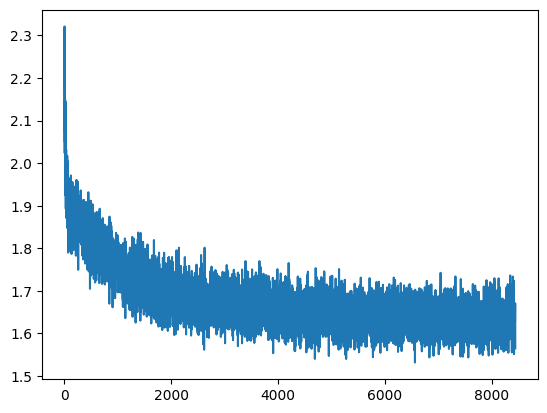

In [19]:

# -----------------------------------------------------------------------------------------------
#Parameters
n_hidden = 16
hid_layers = 3
activation = "tanh"
init = "Xavier"
batch_size=64
lossi = []
nepoch = 10
optimizer = "rmsprop"

# -----------------------------------------------------------------------------------------------

X = train_images.reshape(train_images.shape[0], -1)/ 255.0
Y = train_labels
Y = np.eye(10)[Y]     #one_hot encoding


# -----------------------------------------------------------------------------------------------
#Model

# Define layer sizes
layer_sizes = [784, 1024, 512, 256, 128, 64]
layer_sizes = layer_sizes[:hid_layers]


if activation == "tanh":
  print("Activation used is Tanh")

  model = Sequential([Linear(784, layer_sizes[1], weight_init=init)])

  # Hidden layers
  for i in range(1, len(layer_sizes)-1):
      model.append(Tanh())
      model.append(Linear(layer_sizes[i], layer_sizes[i+1], weight_init=init))

  # Final output layer
  model.append(Tanh())
  model.append(Linear(layer_sizes[-1], 10, weight_init=init))  # 128->10


elif activation == "relu":
  print("Activation used is ReLu")
  model = Sequential([Linear(784, layer_sizes[1], weight_init=init)])

  # Hidden layers
  for i in range(1, len(layer_sizes)-1):
      model.append(Relu())
      model.append(Linear(layer_sizes[i], layer_sizes[i+1], weight_init=init))

  # Final output layer
  model.append(Relu())
  model.append(Linear(layer_sizes[-1], 10, weight_init=init))  # 128->10


elif activation == "sigmoid":
  print("Activation used is Sigmoid")
  model = Sequential([Linear(784, layer_sizes[1], weight_init=init)])

  # Hidden layers
  for i in range(1, len(layer_sizes)-1):
      model.append(Sigmoid())
      model.append(Linear(layer_sizes[i], layer_sizes[i+1], weight_init=init))

  # Final output layer
  model.append(Sigmoid())
  model.append(Linear(layer_sizes[-1], 10, weight_init=init))  # 128->10


else:
  raise Exception("Invalid activation function")

# -----------------------------------------------------------------------------------------------
#Training Loop


for epoch in range(nepoch):
  print("-------x-------")
  #Shuffling
  indices = np.random.permutation(X.shape[0])
  X = X[indices]
  Y = Y[indices]
  for i in range(0, train_images.shape[0], batch_size):
    Xb = X[i:i + batch_size]
    Yb = Y[i:i + batch_size]

    # Forward Pass
    logits = model(Xb)
    loss = CrossEntropyLoss()(logits, Yb)

    #Backward Pass
    dout = CrossEntropyLoss().grad(logits, Yb)
    dout = model.backward(dout)

    batch_num = i//batch_size
    total_batch = train_images.shape[0]//batch_size

    # Learning Rate Scheduling
    lr = 1e-4
    # if epoch < 3:
    #   lr = 1e-1
    # else:
    #   lr = 1e-3 if (batch_num*1.25) < total_batch else 1e-5
    # lr = max(lr * 0.5, 1e-5)

    #parameter update
    clip_value=1e-3
    velocity = [np.zeros_like(param) for param in model.parameters()]
    for i, (u, param, grad) in enumerate(zip(velocity, model.parameters(), dout[1])):
        # RMS Prop
        clipped_dparam = np.clip(grad, -clip_value, clip_value)
        u = 0.9 * u + (1 - 0.9) * (clipped_dparam**2)
        param -= ((lr * clipped_dparam)/ (np.sqrt(u + 1e-8)))

        # momentum
        # u = 0.9 * u + 0.1 * clipped_dparam
        # param -= lr * u + clipped_dparam #grad


    if batch_num%200 == 0: # print every once in a while
      print(f'Epoch({epoch+1}/{nepoch})\t Batch({batch_num:2d}/{total_batch:2d}): \tTrain Loss  {loss:.4f}')

    lossi.append(loss)

  logits = model(X)
  train_loss = CrossEntropyLoss()(logits, Y)
  train_accuracy = np.mean(np.argmax(logits, axis=1) == np.argmax(Y, axis=1))

  val_logits = model(val_images.reshape(val_images.shape[0], -1)/ 255.0)
  Yv = np.eye(10)[val_labels]
  val_loss = CrossEntropyLoss()(val_logits, Yv)
  val_accuracy = np.mean(np.argmax(val_logits, axis=1) == np.argmax(Yv, axis=1))

  print(f"End of Epoch: {epoch+1} Train Accuracy: {train_accuracy:.4f} Validation Accuracy: {val_accuracy:.4f}")

# -----------------------------------------------------------------------------------------------
# Test Accuracy
x = test_images
x = x.reshape(x.shape[0], -1)
y = test_labels

#Forward Pass
logits = model(x)
accuracy_formula = np.mean(np.argmax(logits, axis=1) == y)
print(f"Test Accuracy: {accuracy_formula}")

plt.plot(lossi)
plt.show()





[]

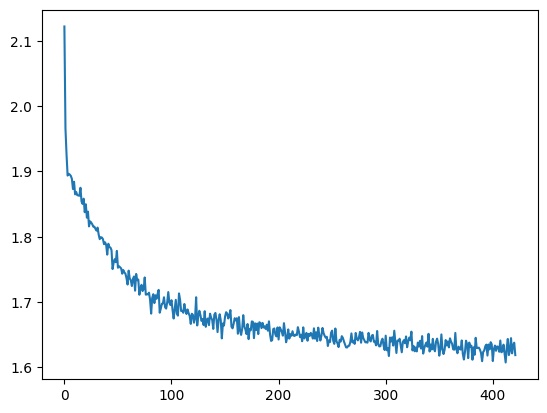

In [20]:
plt.plot(np.array(lossi).reshape(-1, 20).mean(1))
plt.plot()